In [17]:
import skimage, numpy as np, numpy.ma as ma, scipy.ndimage
from matplotlib import pyplot as plt
import skimage.morphology
from skimage.measure import regionprops
import skimage.feature
from MinimumBoundingBox import MinimumBoundingBox

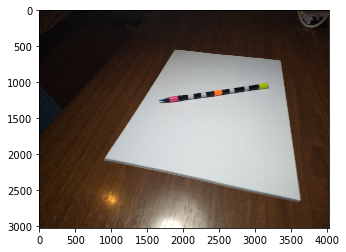

In [18]:
picname = "IMG_20190604_210132054.jpg"
markerpic = plt.imread(f"rendered_markers/Markers/{picname}")
# markerpic = markerpic[:,:,0:3]
plt.figure("marker")
plt.imshow(markerpic)

The hues of the tags are specified in the `hues` array. The process works by selecting regions with enough saturation and value and matching hues; then the center of mass of the regions is computed.

In [23]:
hue_threshold = 0.02
sat_threshold = 0.4
val_threshold = 0.5
closure_radius = 5

smoothpic = skimage.filters.gaussian(markerpic, sigma=3, multichannel=True)
hsvmarker = skimage.color.rgb2hsv(smoothpic)

hues = np.array([0.1861111111, 0.05555555556, 0.95])
satmask = hsvmarker[:,:,1] > sat_threshold
valmask = hsvmarker[:,:,2] > val_threshold

# This is to account for the circularity of hues
huedists = [np.minimum(1 - np.abs(hsvmarker[:,:,0] - hue), np.abs(hsvmarker[:,:,0] - hue)) for hue in hues]
huemasks = [huedist < hue_threshold for huedist in huedists]
# A closing is used to remove highlights in the tags
disk = skimage.morphology.disk(closure_radius)
hsvmasks = [skimage.morphology.binary_closing(huemask & satmask & valmask, selem=disk) for huemask in huemasks]
# regionprops is not very efficient but this is just a PoC.
centroids = np.array([regionprops(hsvmask.astype(int))[0].centroid for hsvmask in hsvmasks])
# The centroids are returned in i,j coordinates, we need to swap them
centroids = centroids[:,[1,0]]

(3122.4351233671982, 1054.9152394775035)
(2492.4796257168728, 1150.292333232719)
(1874.6113537117903, 1237.0851528384283)


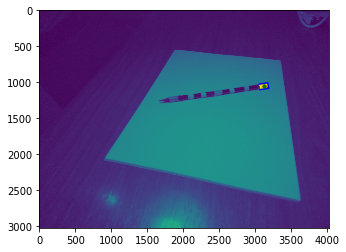

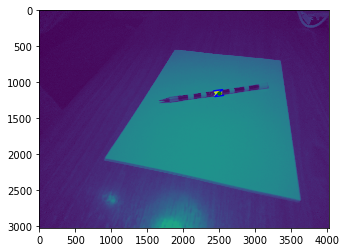

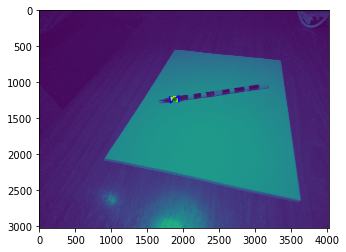

In [24]:
for i, (hsvmask, centroid) in enumerate(zip(hsvmasks, centroids)):
    plt.figure(f"hsvmask {i}")
    plt.imshow(skimage.color.rgb2gray(markerpic)+hsvmask)
    plt.plot(*centroid, 'r.')
    points = [(u, v) for ((v, u), val) in np.ndenumerate(hsvmask) if val]
    bbox = MinimumBoundingBox(points)
    plt.plot(*zip(*bbox.corner_points), 'b-')
    plt.plot(*bbox.rectangle_center, 'g.')
    print(bbox.rectangle_center)
    plt.savefig(f"_hsvmask {i}.png", dpi=600)